Regression_ age + Face prediction 

In [1]:
import os
import json
import cv2
import torch
import numpy as np

from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

In [2]:
def collect_image_age_pairs(image_root_dir, json_root_dir):
    pairs = []

    # subject_id dir 반복
    subject_ids = sorted([d for d in os.listdir(image_root_dir) if os.path.isdir(os.path.join(image_root_dir, d))])

    print(f"총 subject 수: {len(subject_ids)}")

    for subject_id in subject_ids:
        subject_image_dir = os.path.join(image_root_dir, subject_id)
        subject_json_dir = os.path.join(json_root_dir, subject_id)
        if not os.path.exists(subject_json_dir):
            print(f"[경고] JSON 디렉토리 없음: {subject_json_dir}")
            continue
        
        #이미지 파일 중 Jpg만 추출 
        jpg_files = [f for f in os.listdir(subject_image_dir) if f.endswith('.jpg')]

        for jpg_file in jpg_files:
            base_name = jpg_file.replace('.jpg', '')    
            json_filename = f"{base_name}_00.json"
            json_path = os.path.join(subject_json_dir, json_filename)
            jpg_path = os.path.join(subject_image_dir, jpg_file)

            if os.path.exists(json_path):
                try:
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        age = data['info']['age'] #info[4]
                        pairs.append((jpg_path, age))
                        
                except Exception as e:
                    print(f"[오류] JSON 파싱 실패: {json_path} - {e}")
            else:
                print(f"[경고] JSON 파일 없음: {json_path}")

    return pairs

In [3]:
# 루트 경로 설정  
image_root = '/home/alpaco/yskim/data/Training/origin/digitalCamera'
json_root = '/home/alpaco/yskim/data/Training/lable/digitalCamera'

# 실행 
image_age_pairs = collect_image_age_pairs(image_root, json_root)

# 결과
print(f"총 매칭 이미지 수: {len(image_age_pairs)}")
print("샘플 10:")
for i in range(min(10, len(image_age_pairs))):
    print(image_age_pairs[i])

총 subject 수: 858
총 매칭 이미지 수: 6006
샘플 10:
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_L15.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_Fb.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_L30.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_Ft.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_F.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_R15.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_R30.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_Fb.jpg', 24)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_F.jpg', 24)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_L15.jpg', 24)


In [4]:
import pandas as pd

df = pd.DataFrame(image_age_pairs, columns=['image_path', 'age'])
print(df.head())

                                          image_path  age
0  /home/alpaco/yskim/data/Training/origin/digita...   50
1  /home/alpaco/yskim/data/Training/origin/digita...   50
2  /home/alpaco/yskim/data/Training/origin/digita...   50
3  /home/alpaco/yskim/data/Training/origin/digita...   50
4  /home/alpaco/yskim/data/Training/origin/digita...   50


### EfficientNet 학습
1. data준비
2. custom dataset 클래스 정의
3. 이미지 전처리(transforms)
4. 모델 구성 (ResNet, EfficientNet)
5. Regression Loss (MSELoss)
6. 학습루프 작성(Train/val)
7. 성능평가(MAE, RMSE)

In [5]:
!pip install torch torchvision pandas scikit-learn timm pandas

In [6]:
# Dataset 정의 
class AgeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        image = Image.open(img_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image)
    
        return image, torch.tensor(age, dtype=torch.float32)

In [7]:
!pip install scikit-image

In [8]:
!pip install --upgrade gdown

  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.3
    Uninstalling gdown-4.6.3:
      Successfully uninstalled gdown-4.6.3


In [9]:
!pip install gdown==v4.6.3

  Using cached gdown-4.6.3-py3-none-any.whl.metadata (4.4 kB)
Using cached gdown-4.6.3-py3-none-any.whl (14 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [10]:
%matplotlib inline

In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
# Horizontal Equalizing
image_root = '/home/alpaco/yskim/data/Training/origin/digitalCamera'
output_folder = '/home/alpaco/yskim/data/Training/CLAHE/digitalCamera'
os.makedirs(output_folder, exist_ok=True)

image_files = [f for f in os.listdir(image_root) if f.lower().endswith('.jpg')]

for file in image_files:
    image_path = os.path.join(image_root, file)
    image = io.imread(image_path)

    if image.ndim == 3:
        image_gray = rgb2gray(image)
    else:
        image_gray = image

    equalized = exposure.equalize_adapthist(image_gray, clip_limit=0.03)
    output_path = os.path.join(output_folder, f'equalized_{file}')
    io.imsave(output_path, img_as_ubyte(equalized))
    print(f"Saved: {output_path}")

In [13]:
# Custom Data

class AgeRegressionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age, dtype=torch.float32)

In [14]:
# transform 정의 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
# pip uninstall torch torchvision -y
# pip install torch==2.1.2 torchvision==0.16.2 --index-url https://download.pytorch.org/whl/cpu

In [15]:
#정상작동 확인
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:
# dataloader 구성
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

df = pd.DataFrame(image_age_pairs, columns=['image_path', 'age'])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = AgeDataset(train_df, transform=transform)
val_dataset = AgeDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
#EfficientNet
import torch.nn as nn
import timm  

class EfficientNetRegressor(nn.Module):
    def __init__(self):
        super(EfficientNetRegressor, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, 1)  # 회귀용 출력
        
    def forward(self, x):
        return self.backbone(x).squeeze(1)

/home/alpaco/anaconda3/envs/alpacosry/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# 학습루프 
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import ImageFile
from skimage import io, exposure, img_as_ubyte
from skimage.color import rgb2gray

ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetRegressor().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

##성능개선_(1)

optimizer Adam with lr=0.001
Epoch loop : 학습과 검증을 하나의 loop에 통합
Early stopping : val_loss 기준 patient= 3 
성능기록 및 시각화 = loss,MAE,RMSE

In [20]:
#전체 통합(학습&검증)

# optimizer & criterion
# Optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler 설정 (validation loss 기준)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
criterion = torch.nn.MSELoss() 

# early stopping 변수 설정
best_val_loss = float('inf')
patience = 3
counter = 0
best_model_wts = None

# 기록용 리스트
train_loss_history = []
train_mae_history = []
train_rmse_history = []

val_loss_history = []
val_mae_history = []
val_rmse_history = []

num_epochs = 30
#학습률 확인 -------------------------------
for param_group in optimizer.param_groups:
    print("Current LR:", param_group['lr'])
#학습 및 검증 ------------------------------
for epoch in range(num_epochs):
    # ---------- TRAIN ----------
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, ages in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        images, ages = images.to(device), ages.to(device)

        preds = model(images).squeeze()
        loss = criterion(preds, ages.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(ages.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = mean_absolute_error(all_labels, all_preds)
    epoch_rmse = mean_squared_error(all_labels, all_preds, squared=False)

    train_loss_history.append(epoch_loss)
    train_mae_history.append(epoch_mae)
    train_rmse_history.append(epoch_rmse)

    # ---------- VALIDATION ----------
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, ages in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation"):
            images, ages = images.to(device), ages.to(device)

            preds = model(images).squeeze()
            loss = criterion(preds, ages.float())

            val_running_loss += loss.item() * images.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(ages.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_mae = mean_absolute_error(val_labels, val_preds)
    val_rmse = mean_squared_error(val_labels, val_preds, squared=False)

    val_loss_history.append(val_loss)
    val_mae_history.append(val_mae)
    val_rmse_history.append(val_rmse)

    print(f"[Epoch {epoch+1}] Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f}")

    # ---------- EARLY STOPPING ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_wts = model.state_dict()  # 가중치 저장
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

# 최고 모델 복원
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

Current LR: 0.001


[Epoch 1] Validation: 100%|██████████| 38/38 [03:03<00:00,  4.83s/it]


[Epoch 1] Train Loss: 348.3347 | Val Loss: 66.5984 | MAE: 6.5434 | RMSE: 8.1608


[Epoch 2] Validation: 100%|██████████| 38/38 [01:54<00:00,  3.02s/it]


[Epoch 2] Train Loss: 25.2611 | Val Loss: 18.5182 | MAE: 2.9899 | RMSE: 4.3033


[Epoch 3] Validation: 100%|██████████| 38/38 [01:59<00:00,  3.14s/it]


[Epoch 3] Train Loss: 18.1226 | Val Loss: 16.6714 | MAE: 2.8127 | RMSE: 4.0831


[Epoch 4] Validation: 100%|██████████| 38/38 [02:11<00:00,  3.47s/it]


[Epoch 4] Train Loss: 14.4687 | Val Loss: 14.8733 | MAE: 2.6153 | RMSE: 3.8566


[Epoch 5] Validation: 100%|██████████| 38/38 [02:16<00:00,  3.59s/it]


[Epoch 5] Train Loss: 12.1345 | Val Loss: 27.3191 | MAE: 3.8892 | RMSE: 5.2268


[Epoch 6] Validation: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it]


[Epoch 6] Train Loss: 17.6871 | Val Loss: 53.0747 | MAE: 6.2466 | RMSE: 7.2852


[Epoch 7] Validation: 100%|██████████| 38/38 [03:03<00:00,  4.83s/it]

[Epoch 7] Train Loss: 15.8206 | Val Loss: 19.6130 | MAE: 3.2258 | RMSE: 4.4287
Early stopping at epoch 7. Best Val Loss: 14.8733


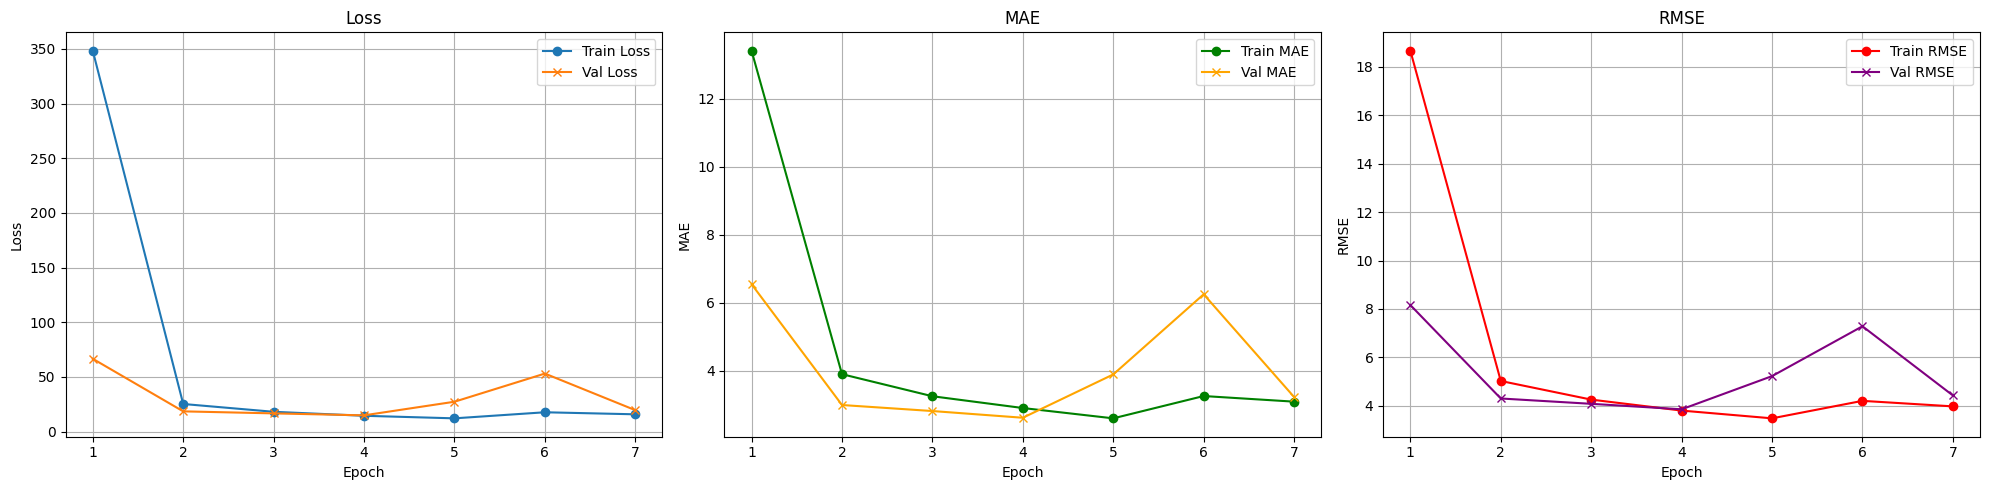

In [24]:
# 모델 시각화 
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(20, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_history, marker='o', label='Train Loss')
plt.plot(epochs, val_loss_history, marker='x', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, train_mae_history, marker='o', label='Train MAE', color='green')
plt.plot(epochs, val_mae_history, marker='x', label='Val MAE', color='orange')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# 3. RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse_history, marker='o', label='Train RMSE', color='red')
plt.plot(epochs, val_rmse_history, marker='x', label='Val RMSE', color='purple')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
#모델 저장 
torch.save(best_model_wts, 'best_model.pth')

##성능개선_(2)

optimizer Adam with lr=0.001

Early stopping : val_loss 기준 patient= 5 
성능기록 및 시각화 = loss,MAE,RMSE

In [ ]:
#전체 통합(학습&검증)_2

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler 설정 (validation loss 기준)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=25, verbose=True
)
criterion = torch.nn.MSELoss() 

# early stopping 변수 설정
best_val_loss = float('inf')
patience = 5
counter = 0
best_model_wts = None

# 기록용 리스트
train_loss_history = []
train_mae_history = []
train_rmse_history = []

val_loss_history = []
val_mae_history = []
val_rmse_history = []

num_epochs = 30
#학습률 확인 -------------------------------
for param_group in optimizer.param_groups:
    print("Current LR:", param_group['lr'])
#학습 및 검증 ------------------------------
for epoch in range(num_epochs):
    # ---------- TRAIN ----------
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, ages in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        images, ages = images.to(device), ages.to(device)

        preds = model(images).squeeze()
        loss = criterion(preds, ages.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(ages.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = mean_absolute_error(all_labels, all_preds)
    epoch_rmse = mean_squared_error(all_labels, all_preds, squared=False)

    train_loss_history.append(epoch_loss)
    train_mae_history.append(epoch_mae)
    train_rmse_history.append(epoch_rmse)

    # ---------- VALIDATION ----------
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, ages in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation"):
            images, ages = images.to(device), ages.to(device)

            preds = model(images).squeeze()
            loss = criterion(preds, ages.float())

            val_running_loss += loss.item() * images.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(ages.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_mae = mean_absolute_error(val_labels, val_preds)
    val_rmse = mean_squared_error(val_labels, val_preds, squared=False)

    val_loss_history.append(val_loss)
    val_mae_history.append(val_mae)
    val_rmse_history.append(val_rmse)

    print(f"[Epoch {epoch+1}] Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f}")

    # ---------- EARLY STOPPING ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_wts = model.state_dict()  # 가중치 저장
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

# 최고 모델 복원
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

In [ ]:
# 모델 시각화_2
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_history, marker='o', label='Train Loss 2')
plt.plot(epochs, val_loss_history, marker='x', label='Val Loss 2')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, train_mae_history, marker='o', label='Train MAE 2', color='green')
plt.plot(epochs, val_mae_history, marker='x', label='Val MAE 2', color='orange')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# 3. RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse_history, marker='o', label='Train RMSE 2', color='red')
plt.plot(epochs, val_rmse_history, marker='x', label='Val RMSE 2', color='purple')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#모델 저장_2
torch.save(best_model_wts2, 'best_model.pth2')